In [18]:
import json
import requests
import pandas as pd
import datetime

# Load API keys
with open("alpaca_keys.json", "r") as file:
    data = json.load(file)

alpaca_key = data['alpaca_key']
alpaca_secret = data['alpaca_secret']

# Alpaca API endpoints
base_url = "https://paper-api.alpaca.markets"
orders_url = f"{base_url}/v2/orders"

headers = {
    "APCA-API-KEY-ID": alpaca_key,
    "APCA-API-SECRET-KEY": alpaca_secret
}

# Define time segments
start_date_1 = "2025-01-10"
end_date_1 = "2025-01-17"
start_date_2 = "2025-01-17"
end_date_2 = datetime.datetime.today().strftime('%Y-%m-%d')

# Function to fetch trades in a given timeframe
def fetch_trades(start_date, end_date):
    trade_data = []
    params = {
        "status": "filled",
        "limit": 500,
        "after": start_date,
        "until": end_date
    }
    
    while True:
        response = requests.get(orders_url, headers=headers, params=params)
        if response.status_code == 200:
            data = response.json()
            if not data:
                break
            trade_data.extend(data)

            # Check if pagination exists
            if "next_page_token" in response.headers:
                params["page_token"] = response.headers["next_page_token"]
            else:
                break
        else:
            print("Error fetching trades:", response.text)
            break

    return pd.DataFrame([
        {
            "symbol": trade["symbol"],
            "side": trade["side"],
            "qty": float(trade["qty"]),
            "filled_avg_price": float(trade["filled_avg_price"]),
            "timestamp": trade["filled_at"]
        }
        for trade in trade_data
    ])

# Fetch trades in two segments
df_trades_1 = fetch_trades(start_date_1, end_date_1)
df_trades_2 = fetch_trades(start_date_2, end_date_2)

# Combine dataframes
df_trades = pd.concat([df_trades_1, df_trades_2]).sort_values(by="timestamp").reset_index(drop=True)

# Convert timestamps
df_trades['timestamp'] = pd.to_datetime(df_trades['timestamp'])

# Check for duplicate rows
duplicates = df_trades.duplicated()

if duplicates.sum() > 0:
    print(f"Found {duplicates.sum()} duplicate rows. Removing them...")
    df_trades = df_trades.drop_duplicates().reset_index(drop=True)
else:
    print("No duplicate rows found.")

# Display the updated DataFrame
display(df_trades)



No duplicate rows found.


,symbol,side,qty,filled_avg_price,timestamp
0,BTC/USD,buy,0.005,94294.140,2025-01-11 08:23:52.647593+00:00
1,BTC/USD,buy,0.005,94294.140,2025-01-11 08:24:50.588726+00:00
2,BTC/USD,sell,0.005,94322.352,2025-01-11 08:30:04.682492+00:00
3,BTC/USD,buy,0.005,94285.376,2025-01-11 08:36:12.247020+00:00
4,BTC/USD,buy,0.005,94291.100,2025-01-11 08:36:26.547781+00:00
...,...,...,...,...,...
912,BTC/USD,sell,0.004,105724.097,2025-01-30 16:43:04.268114+00:00
913,BTC/USD,sell,0.004,105725.200,2025-01-30 16:44:08.338558+00:00
914,BTC/USD,buy,0.004,105863.495,2025-01-30 16:44:23.580025+00:00
915,BTC/USD,buy,0.004,105815.753,2025-01-30 16:45:31.114945+00:00


In [19]:
import json
import requests
import pandas as pd
from datetime import datetime

# Load API keys
with open("alpaca_keys.json", "r") as file:
    data = json.load(file)

alpaca_key = data['alpaca_key']
alpaca_secret = data['alpaca_secret']

# Alpaca API endpoint
portfolio_url = "https://paper-api.alpaca.markets/v2/account/portfolio/history"

headers = {
    "APCA-API-KEY-ID": alpaca_key,
    "APCA-API-SECRET-KEY": alpaca_secret
}

# Define start and end dates in YYYY-MM-DD format
start_date = "2025-01-10"
end_date = datetime.today().strftime('%Y-%m-%d')

# Set parameters for crypto accounts
params = {
    "date_start": start_date,
    "date_end": end_date,
    "timeframe": "1H",  # Hourly intervals
    "intraday_reporting": "continuous",
    "pnl_reset": "no_reset"
}

response = requests.get(portfolio_url, headers=headers, params=params)

if response.status_code == 200:
    portfolio_data = response.json()
    if portfolio_data and "equity" in portfolio_data:
        df_equity = pd.DataFrame({
            "timestamp": pd.to_datetime(portfolio_data["timestamp"], unit="s"),
            "equity": portfolio_data["equity"],
            "profit_loss": portfolio_data["profit_loss"]
        })
        # Display the DataFrame
        display(df_equity)
    else:
        print("No equity data found in the response.")
else:
    print("Error fetching portfolio data:", response.text)


,timestamp,equity,profit_loss
0,2025-01-10 05:00:00,1000000.00,0.00
1,2025-01-10 06:00:00,1000000.00,0.00
2,2025-01-10 07:00:00,1000000.00,0.00
3,2025-01-10 08:00:00,1000000.00,0.00
4,2025-01-10 09:00:00,1000000.00,0.00
...,...,...,...
572,2025-02-03 01:00:00,997897.46,-2102.54
573,2025-02-03 02:00:00,997597.90,-2402.10
574,2025-02-03 03:00:00,997620.90,-2379.10
575,2025-02-03 04:00:00,997671.27,-2328.73


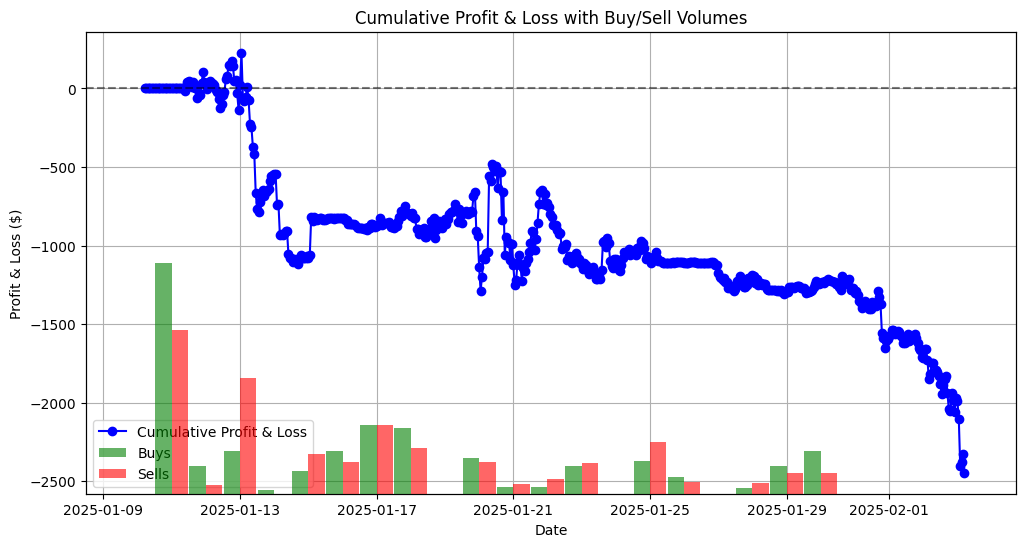

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure timestamps are sorted
df_equity = df_equity.sort_values("timestamp").reset_index(drop=True)

# --- Aggregate Buys and Sells by Day ---
df_trades["date"] = df_trades["timestamp"].dt.date  # Convert to just the date
daily_buys = df_trades[df_trades["side"] == "buy"].groupby("date")["qty"].sum()
daily_sells = df_trades[df_trades["side"] == "sell"].groupby("date")["qty"].sum()

# Align with equity data
df_equity["date"] = df_equity["timestamp"].dt.date
dates = df_equity["date"].unique()

# Fill missing days with 0 volume to ensure consistent length
buy_volumes = daily_buys.reindex(dates, fill_value=0).values  # Convert to array
sell_volumes = daily_sells.reindex(dates, fill_value=0).values  # Convert to array

# Use unique daily timestamps from df_equity
daily_timestamps = df_equity.groupby("date")["timestamp"].first().values  # Ensure timestamps match days

# Compute bar width dynamically
num_days = len(dates)
bar_width = (df_equity["timestamp"].max() - df_equity["timestamp"].min()) / num_days

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot cumulative PnL on the primary y-axis
ax1.plot(df_equity["timestamp"], df_equity["profit_loss"], label="Cumulative Profit & Loss", linestyle="-", marker="o", color="blue")
ax1.axhline(0, color="black", linestyle="--", alpha=0.5)  # Reference line at zero
ax1.set_ylabel("Profit & Loss ($)")
ax1.set_title("Cumulative Profit & Loss with Buy/Sell Volumes")
ax1.legend()
ax1.grid()

# Create a secondary y-axis for the buy/sell bars
ax2 = ax1.twinx()
ax2.set_ylim(0, max(max(buy_volumes), max(sell_volumes))*2)  # Scale y-axis for visibility

# Plot volume bars at the bottom
buy_positions = daily_timestamps - pd.Timedelta(bar_width / 4, "D")  # Shift left
sell_positions = daily_timestamps + pd.Timedelta(bar_width / 4, "D")  # Shift right

ax2.bar(buy_positions, buy_volumes, color="green", width=bar_width/2, label="Buys", align="center", alpha=0.6)
ax2.bar(sell_positions, sell_volumes, color="red", width=bar_width/2, label="Sells", align="center", alpha=0.6)

# Hide y-axis for bars (just for visuals)
ax2.set_yticks([])

# Merge legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2)

ax1.set_xlabel("Date")
plt.xticks(rotation=45)
plt.show()

In [22]:
btc_price_url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
response = requests.get(btc_price_url)

if response.status_code == 200:
    btc_prices = response.json()["prices"]
else:
    print("Error fetching BTC price:", response.text)
    btc_prices = []

df_btc_price = pd.DataFrame(btc_prices, columns=["timestamp", "price"])
df_btc_price["timestamp"] = pd.to_datetime(df_btc_price["timestamp"], unit="ms")
df_btc_price.rename(columns={"price": "close"}, inplace=True)


In [23]:
df_btc_price

,timestamp,close
0,2025-01-04 10:03:50.432,97647.466574
1,2025-01-04 11:03:37.453,97795.825988
2,2025-01-04 12:03:57.997,97853.766867
3,2025-01-04 13:03:40.961,97856.316877
4,2025-01-04 14:04:00.792,97942.476492
...,...,...
714,2025-02-03 06:04:01.126,93885.079888
715,2025-02-03 07:04:21.688,93984.495822
716,2025-02-03 08:03:10.198,95437.748411
717,2025-02-03 09:03:50.939,95431.537853


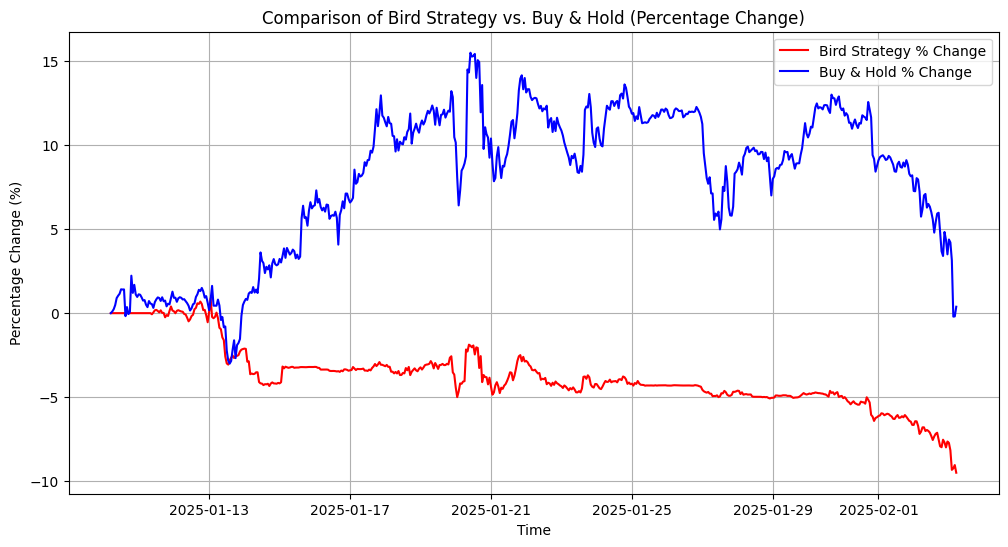

In [24]:
# Ensure dataframes are sorted by timestamp
df_equity = df_equity.sort_values("timestamp")
df_btc_price = df_btc_price.sort_values("timestamp")

# Define the common start date as the later of the two start dates
common_start = max(df_equity["timestamp"].min(), df_btc_price["timestamp"].min())

# Get the BTC price at the common start date.
# This finds the most recent BTC price at or before the common start.
initial_btc_price = df_btc_price.loc[df_btc_price["timestamp"] <= common_start, "close"].iloc[-1]

# Compute max BTC held (assuming you already created df_trades["signed_qty"] and computed cumulative sum)
# If not, first create the cumulative BTC column:
df_trades["signed_qty"] = df_trades["qty"] * df_trades["side"].map({"buy": 1, "sell": -1})
df_trades["cumulative_btc"] = df_trades["signed_qty"].cumsum()
max_btc_held = df_trades["cumulative_btc"].max()

# Compute the initial bankroll using the BTC price at the common start date
initial_bankroll = max_btc_held * initial_btc_price

# Compute the new bankroll for the bird strategy (using cumulative profit/loss from df_equity)
df_equity["new_bankroll_bird"] = df_equity["profit_loss"] + initial_bankroll

# Compute the new bankroll for the buy-and-hold strategy using df_btc_price
df_btc_price["new_bankroll_hold"] = df_btc_price["close"] * max_btc_held

# Merge the equity and BTC price data using merge_asof.
# This aligns each df_equity timestamp with the most recent available BTC price.
df_comparison = pd.merge_asof(
    df_equity[["timestamp", "new_bankroll_bird"]],
    df_btc_price[["timestamp", "new_bankroll_hold"]],
    on="timestamp",
    direction="backward"
)

# Now calculate the percentage change for each strategy relative to initial_bankroll.
df_comparison["pct_change_bird"] = ((df_comparison["new_bankroll_bird"] - initial_bankroll) / initial_bankroll) * 100
df_comparison["pct_change_hold"] = ((df_comparison["new_bankroll_hold"] - initial_bankroll) / initial_bankroll) * 100

# At the common start date (the first row in df_comparison), both strategies will have a value equal to initial_bankroll,
# so the percentage change will be 0 as desired.

# Plot the comparison
plt.figure(figsize=(12, 6))
plt.plot(df_comparison["timestamp"], df_comparison["pct_change_bird"], label="Bird Strategy % Change", color='red')
plt.plot(df_comparison["timestamp"], df_comparison["pct_change_hold"], label="Buy & Hold % Change", color='blue')
plt.xlabel("Time")
plt.ylabel("Percentage Change (%)")
plt.legend()
plt.title("Comparison of Bird Strategy vs. Buy & Hold (Percentage Change)")
plt.grid()
plt.show()
